In [2]:
import pandas as pd

fraud_df = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_df = pd.read_csv("../data/raw/IpAddress_to_Country.csv")

fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [4]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

In [5]:
fraud_df.duplicated().sum()

np.int64(0)

In [6]:
fraud_df.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [7]:
fraud_df['class'].value_counts()

class
0    136961
1     14151
Name: count, dtype: int64

In [8]:
fraud_df['class'].value_counts(normalize=True) * 100

class
0    90.635423
1     9.364577
Name: proportion, dtype: float64

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')

<Axes: >

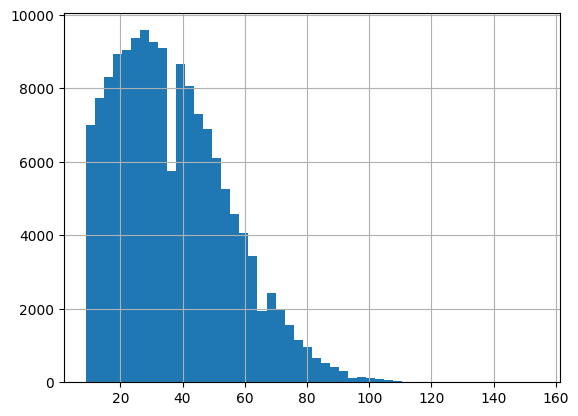

In [12]:
import matplotlib.pyplot as plt
fraud_df['purchase_value'].hist(bins=50)

In [13]:
import numpy as np

fraud_df['purchase_value_log'] = np.log1p(fraud_df['purchase_value'])


<Axes: >

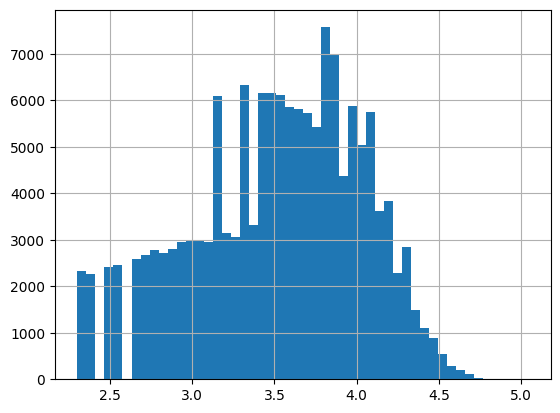

In [14]:
fraud_df['purchase_value_log'].hist(bins=50)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
fraud_df['purchase_value_log_scaled'] = scaler.fit_transform(
    fraud_df[['purchase_value_log']]
)


<Axes: >

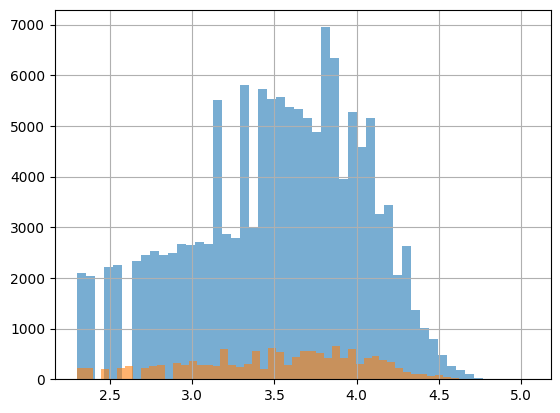

In [17]:
fraud_df[fraud_df['class'] == 0]['purchase_value_log'].hist(bins=50, alpha=0.6)
fraud_df[fraud_df['class'] == 1]['purchase_value_log'].hist(bins=50, alpha=0.6)

In [19]:
fraud_df.groupby('class')['purchase_value_log_scaled'].mean()


class
0    0.000039
1   -0.000375
Name: purchase_value_log_scaled, dtype: float64

In [20]:
fraud_df.groupby('class')['age'].mean()

class
0    33.122356
1    33.318281
Name: age, dtype: float64

In [23]:
fraud_df['ip_address'].dtype

dtype('float64')

In [24]:
fraud_df['ip_address'].head()

0    7.327584e+08
1    3.503114e+08
2    2.621474e+09
3    3.840542e+09
4    4.155831e+08
Name: ip_address, dtype: float64

In [25]:
fraud_df['ip_int'] = fraud_df['ip_address'].astype('int64')

In [27]:
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype('int64')
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype('int64')

In [29]:
ip_df['country'].value_counts().head()

country
United States         46868
Canada                 6989
Russian Federation     6739
Australia              6316
Germany                5999
Name: count, dtype: int64

In [32]:
def get_country(ip_int):
    match = ip_df[
        (ip_df['lower_bound_ip_address'] <= ip_int) &
        (ip_df['upper_bound_ip_address'] >= ip_int)
    ]
    if len(match) > 0:
        return match.iloc[0]['country']
    return 'Unknown'



In [34]:
ip_ranges = ip_df[['lower_bound_ip_address', 'upper_bound_ip_address', 'country']].copy()
ip_ranges = ip_ranges.sort_values('lower_bound_ip_address').reset_index(drop=True)


In [35]:
fraud_df = fraud_df.sort_values('ip_int').reset_index(drop=True)


In [36]:
import numpy as np

# Find index where each ip_int would be inserted
idx = np.searchsorted(
    ip_ranges['lower_bound_ip_address'].values,
    fraud_df['ip_int'].values,
    side='right'
) - 1


In [37]:
fraud_df['country'] = np.where(
    (idx >= 0) &
    (fraud_df['ip_int'].values <= ip_ranges.iloc[idx]['upper_bound_ip_address'].values),
    ip_ranges.iloc[idx]['country'].values,
    'Unknown'
)


In [38]:
fraud_df['country'].value_counts().head()


country
United States     58049
Unknown           21966
China             12038
Japan              7306
United Kingdom     4490
Name: count, dtype: int64

In [39]:
fraud_df[['ip_address', 'country']].sample(5)

,ip_address,country
13448,3.712392e+08,United States
22652,6.230793e+08,Switzerland
56502,1.595100e+09,Spain
100654,2.876116e+09,China
86290,2.451006e+09,United States


In [40]:
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek

In [41]:
fraud_df['time_since_signup'] = (
    fraud_df['purchase_time'] - fraud_df['signup_time']
).dt.total_seconds() / 3600


In [42]:
fraud_df = fraud_df.sort_values(['user_id', 'purchase_time'])

fraud_df['tx_count_1h'] = (
    fraud_df
    .groupby('user_id')['purchase_time']
    .transform(lambda x: x.diff().dt.total_seconds().le(3600).cumsum())
)

In [43]:
from sklearn.preprocessing import StandardScaler

num_cols = ['purchase_value', 'age', 'time_since_signup']
scaler = StandardScaler()

fraud_df[num_cols] = scaler.fit_transform(fraud_df[num_cols])


In [44]:
fraud_df = pd.get_dummies(
    fraud_df,
    columns=['source', 'browser', 'sex'],
    drop_first=True
)

In [47]:
fraud_df['signup_hour'] = fraud_df['signup_time'].dt.hour
fraud_df['purchase_hour'] = fraud_df['purchase_time'].dt.hour
fraud_df['time_diff'] = (
    fraud_df['purchase_time'] - fraud_df['signup_time']
).dt.total_seconds()


In [49]:
fraud_df.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'age', 'ip_address', 'class', 'purchase_value_log',
       'purchase_value_scaled', 'purchase_value_log_scaled', 'ip_int',
       'country', 'hour_of_day', 'day_of_week', 'time_since_signup',
       'tx_count_1h', 'source_Direct', 'source_SEO', 'browser_FireFox',
       'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_M', 'signup_hour',
       'purchase_hour', 'time_diff'],
      dtype='object')

In [50]:
fraud_df = fraud_df.drop(columns=[
    'user_id',
    'device_id',
    'ip_address',
    'signup_time',
    'purchase_time'
])


In [51]:
fraud_df = pd.get_dummies(
    fraud_df,
    columns=['country'],
    drop_first=True
)


In [52]:
fraud_df.dtypes


purchase_value                   float64
age                              float64
class                              int64
purchase_value_log               float64
purchase_value_scaled            float64
                                  ...   
country_Viet Nam                    bool
country_Virgin Islands (U.S.)       bool
country_Yemen                       bool
country_Zambia                      bool
country_Zimbabwe                    bool
Length: 202, dtype: object

In [53]:
bool_cols = fraud_df.select_dtypes(include='bool').columns
fraud_df[bool_cols] = fraud_df[bool_cols].astype(int)


In [54]:
fraud_df.dtypes.value_counts()


int64      191
float64      7
int32        4
Name: count, dtype: int64

In [55]:
X = fraud_df.drop(columns=['class'])
y = fraud_df['class']

In [56]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


In [57]:
y_res.value_counts()
y_res.value_counts(normalize=True)


class
0    0.5
1    0.5
Name: proportion, dtype: float64